In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

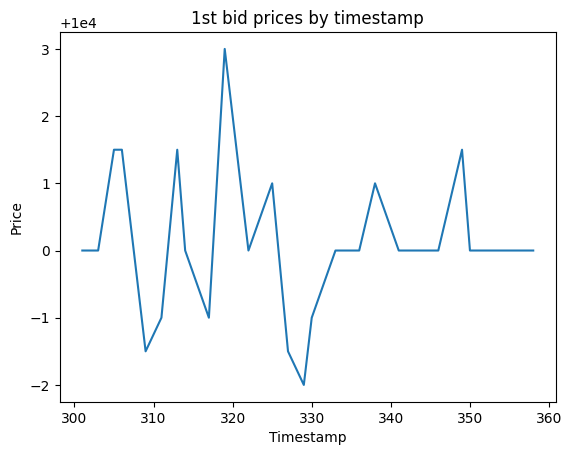

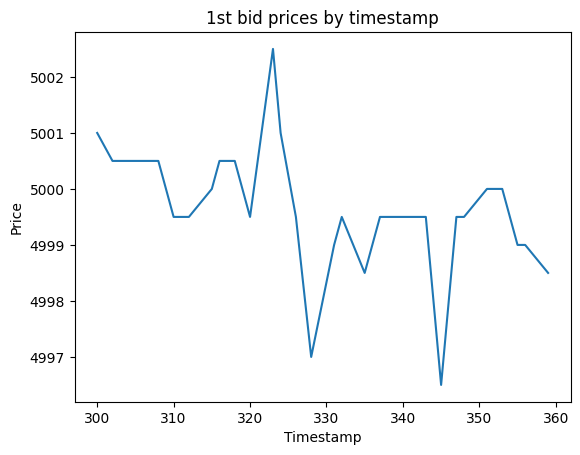

In [6]:
csv_file_path = "./data/round_1/prices_round_1_day_-2.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])

data = {}

for prod in products:
    data[prod] = df[df['product'] == prod]

for prod in products:
    stat = 'mid_price'
    
    plt.title("1st bid prices by timestamp")
    plt.xlabel('Timestamp')
    plt.ylabel('Price')
    plt.plot(data[prod][stat][150:180])
    plt.show()
    
    # prices = np.unique(data[prod][stat], return_counts=True)
    # 
    # plt.title("Counts of 1st bid prices")
    # plt.xlabel('Price')
    # plt.ylabel('Count')
    # plt.plot(prices[0], prices[1])
    # plt.show()
    # 
    # ############
    # 
    # prices_and_volumes = data[prod][['bid_price_1', 'bid_volume_1']]
    # price_volumes = prices_and_volumes.groupby('bid_price_1').agg({'bid_volume_1': 'sum'})
    # 
    # plt.title("Volumes of 1st bid prices")
    # plt.xlabel('Price')
    # plt.ylabel('Volume')
    # plt.plot(price_volumes)
    # plt.show()
    